# Customer Return Analysis using Olist E-Commerce Dataset

#### Goal: Analyze the relationship between customer review scores and return rates
#### Dataset: Kaggle Brazilian E-Commerce Dataset (Olist)

#### Key Questions:
1. Are lower review scores associated with higher return rates?
2. Do certain product categories show significantly different return behaviors?
3. Can return status be predicted based on review scores, delivery information, and payment details?

#### Project Flow:
- Data Collection & Preprocessing  
- Exploratory Data Analysis (EDA)  
- Statistical Testing (t-test, ANOVA, Chi-Square)  
- Regression Analysis (OLS, Logistic Regression)  
- Classification Modeling (Logistic Regression, Random Forest, XGBoost)  
- SMOTE for class imbalance handling  

## 1. Collect Data
#### - Download Dataset from Kaggle, set path, and load CSV file

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

print("Path to dataset files:", path)

Path to dataset files: /Users/yoonji/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2


In [2]:
import os

dataset_path = "/Users/yoonji/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2"
print(os.listdir(dataset_path))  # Check files in the folder

['olist_sellers_dataset.csv', 'product_category_name_translation.csv', 'olist_orders_dataset.csv', 'olist_order_items_dataset.csv', 'olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_products_dataset.csv']


In [3]:
import pandas as pd

# Set file paths
orders_path = dataset_path + "/olist_orders_dataset.csv"
reviews_path = dataset_path + "/olist_order_reviews_dataset.csv"
products_path = dataset_path + "/olist_products_dataset.csv"
order_items_path = dataset_path + "/olist_order_items_dataset.csv"
category_translation_path = dataset_path + "/product_category_name_translation.csv"
payments_path = dataset_path + "/olist_order_payments_dataset.csv"

# Load data
orders = pd.read_csv(orders_path)
reviews = pd.read_csv(reviews_path)
products = pd.read_csv(products_path)
order_items = pd.read_csv(order_items_path)
category_translation = pd.read_csv(category_translation_path)
payments = pd.read_csv(payments_path)


# Check data
print("Order Data:\n", orders.head())
print("\nReview Data:\n", reviews.head())
print("\nProduct Data:\n", products.head())
print("\nOrder Item Data:\n", order_items.head())
print("\nCategory Name Data:\n", category_translation.head())
print("\nPayment Data:\n", payments.head())

Order Data:
                            order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00     

## 2. Data Preprocessing
####  - Merge review scores and return status into one table

In [4]:
# Select necessary columns
orders_short = orders[['order_id', 'customer_id', 'order_status']]
reviews_short = reviews[['order_id', 'review_score']]
order_items_short = order_items[['order_id', 'product_id']]
products_short = products[['product_id', 'product_category_name']]

# Merge order and review data
df = pd.merge(orders_short, reviews_short, on="order_id")

# Create return status column (1 if canceled, else 0)
df['return_status'] = df['order_status'].apply(lambda x: 1 if x == 'canceled' else 0)

# Merge order item and product data
df = pd.merge(df, order_items_short, on="order_id")
df = pd.merge(df, products_short, on="product_id")

# Check data
print(df.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status  review_score  return_status                        product_id  \
0    delivered             4              0  87285b34884572647811a353c7ac498a   
1    delivered             4              0  595fac2a385ac33a80bd5114aec74eb8   
2    delivered             5              0  aa4383b373c6aca5d8797843e5594415   
3    delivered             5              0  d0b61bfb1de832b15ba9d266ca96e5b0   
4    delivered             5              0  65266b2da20d04dbe00c5c2d3bb7859e   

   product_category_name  
0  utilidades_domesticas  
1             perfum

#### Explanation<br>  
Additional Analysis Required: Only return_status = 0 (not returned) rows are shown at the top, so we should check if returned orders exist(return_status == 1).

## 3. Exploratory Data Analysis (EDA)
#### - Basic statistics and relationship between review scores and return status

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check Basic stats
print(df.describe())

# Check for missing values
print("\Missing values in each column: \n", df. isnull().sum ())

# Counts by review score
print("\nData counts by review score:\n", df['review_score'].value_counts ())

# Counts by return status
print("\nData count by return status:\n", df['return_status'].value_counts()) # 1(returned), O (not returned)

# Return rate by review score
review_return_rate = df.groupby('review_score')['return_status'].mean() # Group data by review score to calculate average return rate
print(review_return_rate)

        review_score  return_status
count  112372.000000  112372.000000
mean        4.032473       0.004708
std         1.387849       0.068450
min         1.000000       0.000000
25%         4.000000       0.000000
50%         5.000000       0.000000
75%         5.000000       0.000000
max         5.000000       1.000000
\Missing values in each column: 
 order_id                    0
customer_id                 0
order_status                0
review_score                0
return_status               0
product_id                  0
product_category_name    1598
dtype: int64

Data counts by review score:
 review_score
5    63525
4    21315
1    14235
3     9423
2     3874
Name: count, dtype: int64

Data count by return status:
 return_status
0    111843
1       529
Name: count, dtype: int64
review_score
1    0.028381
2    0.009035
3    0.003608
4    0.000610
5    0.000677
Name: return_status, dtype: float64


#### Explanation<br>
Return data exists, so we can analyze the relationship between review scores and return rates.

#### - Data Visualization

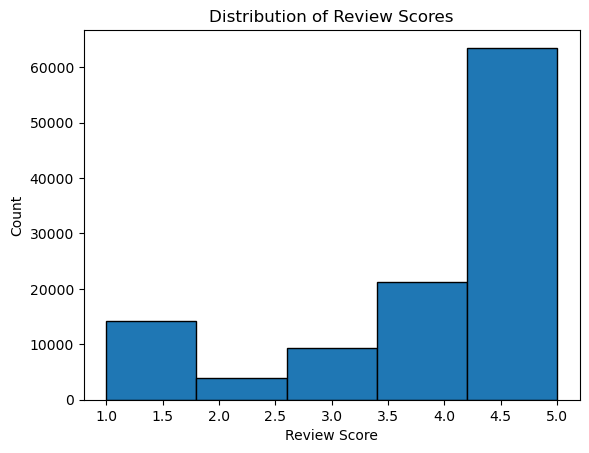

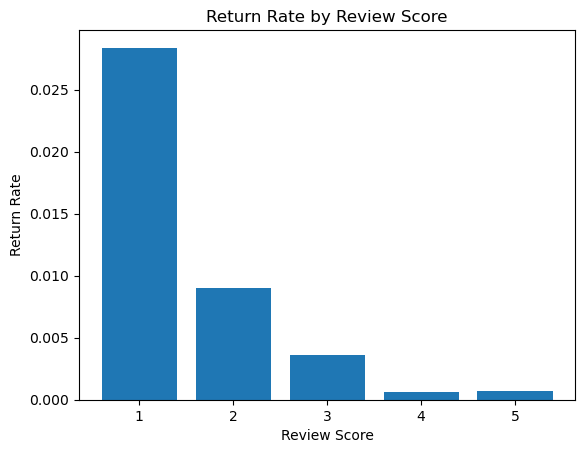

In [6]:
# Histogram of review scores
plt.hist(df['review_score'], bins=5, edgecolor='black')
plt.xlabel ("Review Score")
plt.ylabel ("Count")
plt.title("Distribution of Review Scores")
plt.show()

# Bar chart: return rate by review score
plt.bar(review_return_rate.index, review_return_rate.values)
plt.xlabel('Review Score')
plt.ylabel('Return Rate')
plt.title('Return Rate by Review Score')
plt.show()

               review_score  return_status
review_score       1.000000      -0.120858
return_status     -0.120858       1.000000


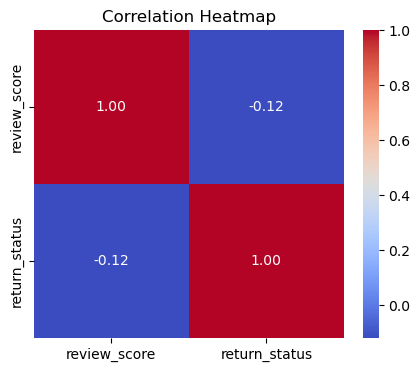

In [7]:
# Correlation between review score and return status
correlation = df[['review_score', 'return_status']].corr()
print(correlation)
# correlation = -0.12, weak negative relationship

# Heatmap of correlation
plt.figure(figsize=(5, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
# Red (1.00): Strong Positive Relationship (itself)
# Blue (-0.12): Weak Negative Relationship

#### Explanation<br>  
**Correlation coefficient**<br>  
- correlation = -0.12: Weak negative correlation  
- Lower review scores are slightly associated with a higher return rate, but the relationship is not strong.  

**Heatmap analysis**<br>  
- The correlation between review_score and return_status is -0.12 (blue), meaning a slightly increased return rate with lower scores. However, the relationship is not strong, so - there may be more influential factors.  

**Additional Analysis Required**<br>  
- Relationship between price and return rate
- Delivery time and return status
- Return rate by product category

## 4. Statistical Analysis and Hypothesis Testing
#### - T-test for difference in return rates between low and high review scores
**Hypotheses**<br>  
H₀: No difference in return rates between low and high score groups<br>  
H₁: Low score group has higher return rates

In [8]:
from scipy.stats import ttest_ind

# t-test
low = df[df['review_score'] <= 2]['return_status']
high = df[df['review_score'] >= 4]['return_status']

t_stat, p_value = ttest_ind(low, high, equal_var=False) # ttest_ind(x, y)
print("t-statistic:", t_stat, "p-value:", p_value)

t-statistic: 20.571767865353408 p-value: 5.514690293693966e-93


#### Explanation<br>
p-value < 0.05: Reject H₀ — there is a statistically significant difference in return rates based on review score.

#### - ANOVA test for return rate differences by product category
**Hypotheses**<br>  
H₀: No difference in return rates across product categories<br>  
H₁: At least one category has a different return rate

In [9]:
from scipy.stats import f_oneway

# Merge English category names: Check the category name
merged_df = pd.merge(products, category_translation, on='product_category_name', how='left')
df = pd.merge(df, merged_df[['product_id', 'product_category_name_english']], on='product_id', how='left')
print("Product Category Name in English:\n", df['product_category_name_english'].unique())

# Groups for ANOVA: Extract groups to use for comparing return rates by category
electronics = df[df['product_category_name_english'] == 'electronics']['return_status']
furniture = df[df['product_category_name_english'] == 'furniture_decor']['return_status']
fashion = df[df['product_category_name_english'] == 'fashion_male_clothing']['return_status']

# Sample size
# print("\nThe number of data in each category")
# print("Electronics:", len(electronics))
# print("Furniture:", len(furniture))
# print("Fashion:", len(fashion))

# ANOVA
anova_result = f_oneway(electronics, furniture, fashion)
print("\nF-statistic:", anova_result.statistic, "p-value:", anova_result.pvalue)

Product Category Name in English:
 ['housewares' 'perfumery' 'auto' 'pet_shop' 'stationery' nan
 'furniture_decor' 'office_furniture' 'garden_tools'
 'computers_accessories' 'bed_bath_table' 'toys' 'telephony'
 'health_beauty' 'electronics' 'baby' 'cool_stuff' 'watches_gifts'
 'air_conditioning' 'sports_leisure' 'books_general_interest'
 'construction_tools_construction' 'small_appliances' 'food'
 'luggage_accessories' 'fashion_underwear_beach' 'christmas_supplies'
 'fashion_bags_accessories' 'musical_instruments'
 'construction_tools_lights' 'books_technical' 'costruction_tools_garden'
 'home_appliances' 'market_place' 'agro_industry_and_commerce'
 'party_supplies' 'home_confort' 'cds_dvds_musicals'
 'industry_commerce_and_business' 'consoles_games' 'furniture_bedroom'
 'construction_tools_safety' 'fixed_telephony' 'drinks'
 'kitchen_dining_laundry_garden_furniture' 'fashion_shoes'
 'home_construction' 'audio' 'home_appliances_2' 'fashion_male_clothing'
 'cine_photo' 'furniture_living

#### Explanation<br>  
p-value = 0.8192 > 0.05: Do not reject H₀ — no statistically significant difference in return rates among the three categories.

#### - Chi-Square Test for independence between category and return status
**Hypotheses**<br>  
H₀: Product category and return status are independent<br>  
H₁: Product category and return status are related

In [10]:
from scipy.stats import chi2_contingency

# Create contingency table
contingency_table = pd.crosstab(df['product_category_name'], df['return_status'])

# Chi-Square
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-square statistic:", chi2, "p-value:", p)

Chi-square statistic: 207.70715362160462 p-value: 4.294503050782418e-15


#### Explanation<br>  
p-value < 0.05: Reject H₀ — product category and return status are related.

#### - Linear Regression: Does review score influence return rate?
**Hypotheses**<br>  
H₀: Review score has no impact on return rate<br>  
H₁: Lower review score increases return rate

In [11]:
import statsmodels.api as sm

# Set the independent variable (x) and dependent variable (y)
X = df[['review_score']]
y = df['return_status']

# Add a constant term (with intercept)
X = sm.add_constant(X)
# Without an intercept, the line must pass through (0,0). Adding an intercept allows you to find the best-fit regression line even if the data does not go past the origin.

# Regression model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          return_status   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1666.
Date:                Mon, 30 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:34:20   Log-Likelihood:             1.4272e+05
No. Observations:              112372   AIC:                        -2.854e+05
Df Residuals:                  112370   BIC:                        -2.854e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0287      0.001     46.149   

#### Explanation<br>  
- R² = 0.015 (very low): Only 1.5% of variance explained
- Coefficients:<br>
Intercept = 0.0287 (return rate when score = 0)<br>
review_score = -0.0060 (each 1-point increase in score reduces return rate by 0.6%)
- P>|t| = 0.000 (p-value < 0.05): reject H0 (statistically significant) → The lower the review score, the higher the return rate.

**Interpretation**<br>  
The explanatory power is low → consider multiple regression with more variables.

#### - Multiple Linear Regression: Analyze other influencing factors

In [12]:
import numpy as np
import statsmodels.api as sm

# Create delivery delay variable
# Convert to a date type
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Create a late delivery status
orders['delivery_late'] = (orders['order_delivered_customer_date'] > orders['order_estimated_delivery_date']).astype(int)

# Extract only the columns
orders_late = orders[['order_id', 'delivery_late']]

# Calculate total price
# Calculate the total amount paid per order
order_price = payments.groupby("order_id")["payment_value"].sum().reset_index()

# Change name
order_price.rename(columns={"payment_value": "total_price"}, inplace=True)

# Merge with main df
df = pd.merge(df, orders_late, on='order_id', how='left')
df = pd.merge(df, order_price, on='order_id', how='left')

# Check if it was merged into df
print(df.columns)

# Multiple Regression
# Select features
features = ['review_score', 'delivery_late', 'total_price']

# Drop missing(NaN) or infinite(inf)
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=features + ['return_status'])

# Define the independent variable (x) and dependent variable (y)
X = df[features]
y = df['return_status']

# Adding Constants
X = sm.add_constant(X)

# Regression model
model = sm.OLS(y, X).fit()

# Print Result
print(model.summary())

Index(['order_id', 'customer_id', 'order_status', 'review_score',
       'return_status', 'product_id', 'product_category_name',
       'product_category_name_english', 'delivery_late', 'total_price'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:          return_status   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     698.4
Date:                Mon, 30 Jun 2025   Prob (F-statistic):               0.00
Time:                        22:34:20   Log-Likelihood:             1.4293e+05
No. Observations:              112369   AIC:                        -2.858e+05
Df Residuals:                  112365   BIC:                        -2.858e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                            

#### Explanation<br>  
- R² = 0.018 (still low): Slight influence from variables
- P>|t| = 0.000 (p-value < 0.05): reject H0 → The lower the review score, the more delayed the delivery, the higher the probability of return.
- Interpretation: Price has a small impact<br>
→ Add more variables (category, region, payment type, etc.) for improved prediction<br>
→ Move to modeling stage for prediction



**Interpretation**<br>  
To initially examine the influence of variables, I used OLS regression and found that review score, price, and delivery delay had statistically significant effects. Since `return_status` is a binary variable, I then applied logistic regression and classification models (Random Forest, XGBoost) to compare performance.

## 5. Modeling

In [13]:
from sklearn.model_selection import train_test_split
X = df[features]  # the descriptive variable we defined earlier
y = df['return_status']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Create Logistic Regression Model
model = LogisticRegression(class_weight='balanced', max_iter=1000)

# Training
model.fit(X_train, y_train)

# Predictions (using the original test set)
y_pred = model.predict(X_test)

# Performance evaluation output
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93     22366
           1       0.03      0.81      0.06       108

    accuracy                           0.88     22474
   macro avg       0.51      0.84      0.50     22474
weighted avg       0.99      0.88      0.93     22474

[[19652  2714]
 [   21    87]]


#### Explanation<br>
Total test samples: 22,474<br>
Returned orders: 108 (highly imbalanced)
- Accuracy: 0.88
- Recall: 0.81 (captures 91% of actual returns)<br>
- Precision: 0.03 (only 3% of predicted returns are correct) → Overpredicting returns<br>
- Additional Analysis Required: Apply SMOTE to handle imbalance

**Interpretation**<br>  
The logistic regression model was trained using class weights to handle imbalance.  
It achieved high recall (0.81) for the minority class (returns), but the precision was very low (0.03), indicating a high false positive rate.  
While overall accuracy was 88%, the performance on the minority class was poor, suggesting the need for oversampling techniques like SMOTE to improve prediction quality for returns.

#### - Reduce data imbalance (SMOTE)

In [15]:
# SMOTE Oversampling
from imblearn.over_sampling import SMOTE

# SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) # resample only in train data
y_resampled.value_counts()

return_status
0    89474
1    89474
Name: count, dtype: int64

In [16]:
resampled_model = LogisticRegression(max_iter=1000)
resampled_model.fit(X_resampled, y_resampled)

# Predictions (using the original test set)
y_pred_re = resampled_model.predict(X_test)

# Performance evaluation output
print(classification_report(y_test, y_pred_re))
print(confusion_matrix(y_test, y_pred_re))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     22366
           1       0.03      0.79      0.06       108

    accuracy                           0.88     22474
   macro avg       0.52      0.84      0.50     22474
weighted avg       0.99      0.88      0.93     22474

[[19756  2610]
 [   23    85]]


**Interpretation**<br>  
Logistic Regression Results after Applying SMOTE:<br>  
After applying SMOTE to address class imbalance in the training data, the logistic regression model was retrained. However, the test performance remained nearly the same.<br>
In particular, the recall for the minority class (returns) slightly decreased, while precision and f1-score showed no significant improvement.<br>  

Possible reasons for this outcome:<br>  
- SMOTE only affects the training data, while the test set remains imbalanced.<br>  
- Logistic regression is a linear model and may not capture complex or non-linear relationships in the data.<br>  
- The synthetic samples generated by SMOTE might not fully reflect the true distribution of the minority class.<br>  

As a next step, applying tree-based models such as Random Forest or XGBoost is recommended to better capture non-linear patterns and improve prediction performance.

#### - Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create Random Forest Model
rf_model = RandomForestClassifier(random_state=42)

# Training (using oversampled data)
rf_model.fit(X_resampled, y_resampled)

# Predictions (using the original test set)
y_pred_rf = rf_model.predict(X_test)

# Performance evaluation output
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98     22366
           1       0.06      0.57      0.10       108

    accuracy                           0.95     22474
   macro avg       0.53      0.76      0.54     22474
weighted avg       0.99      0.95      0.97     22474

[[21334  1032]
 [   46    62]]


#### Explanation<br>  
- Accuracy = 0.95<br>  
- Recall = 0.57 (57% of returns are predicted correctly)<br>  
- Precision = 0.06 (6% of those predicted to be returns are actually returns)<br>  
- F1-score = 0.10 (low, but better than the previous model)

**Interpretation**<br>  
Random Forest Results (with SMOTE):<br>  

The Random Forest model trained on SMOTE-resampled data achieved strong performance for the majority class (non-returns), with high precision (1.00) and recall (0.95).<br>
For the minority class (returns), recall reached 0.57 and precision improved to 0.06 (doubling from the logistic regression model).<br>
The f1-score also increased to 0.10, showing that Random Forest captured more meaningful patterns than logistic regression.<br>  

As a next step, apply XGBoost model to further improve performance on the minority class.

#### - XGBoost

In [18]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create XGBoost Model
xgb_model = xgb.XGBClassifier(random_state=42)

# Training (using oversampled data)
xgb_model.fit(X_resampled, y_resampled)

# Predictions (using the original test set)
y_pred_xgb = xgb_model.predict(X_test)

# Performance evaluation output
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     22366
           1       0.03      0.76      0.06       108

    accuracy                           0.88     22474
   macro avg       0.51      0.82      0.50     22474
weighted avg       0.99      0.88      0.93     22474

[[19707  2659]
 [   26    82]]


#### Explanation<br>  
- Accuracy = 0.88
- Recall = 0.76 (76% of returns are detected) → fairly good performance<br>  
- Precision = 0.03 (3% of returns predicted are actually returns) → still low<br>  
- F1-score = 0.06 (impacted by low precision)

**Interpretation**<br>  

XGBoost Results (with SMOTE):<br>  

The XGBoost model trained on SMOTE-resampled data achieved a recall of 0.76 for the minority class (returns), showing strong ability to detect actual return cases.<br>
However, the precision remained low at 0.03, indicating a high number of false positives.<br>
The f1-score for the return class was 0.06, similar to previous models.<br>  

Compared to Random Forest, XGBoost showed higher recall but lower precision, resulting in a trade-off between detecting returns and avoiding incorrect predictions.<br>
This suggests that while XGBoost is effective at capturing return cases, further steps such as threshold tuning or precision-focused optimization may be needed.

#### Model Comparison & Evaluation

To evaluate the performance of the models, we focused not only on accuracy but also on recall, precision, and F1-score for the minority class (returns = 1), which is crucial in imbalanced classification tasks.

- Logistic model (after SMOTE):
  - **Accuracy**: 88%
  - **Recall (for returns)**: 79%
  - **Precision**: 3%
  - **F1-score**: 6%
- Random Forest model:
  - **Accuracy**: 95%
  - **Recall (for returns)**: 57%
  - **Precision**: 6%
  - **F1-score**: 10%
- XGBoost model:
  - **Accuracy**: 88%
  - **Recall (for returns)**: 76%
  - **Precision**: 3%
  - **F1-score**: 6%  
<br>  

- **Accuracy** is not the most reliable metric due to class imbalance.
- **F1-score** provides a better balance between precision and recall.

#### Conclusion
The **Random Forest** model shows the best overall performance with the highest F1-score and precision, making it the most suitable final model. 
Since the return class is highly imbalanced and our business interest lies in identifying potential returns, I focused on recall and F1-score of the positive class (returned items) as primary evaluation metrics.
However, if the goal is to maximize detection of returns (i.e., prioritize recall), Logistic Regression or XGBoost could also be reasonable choices.

#### - Visualize performance comparisons by model

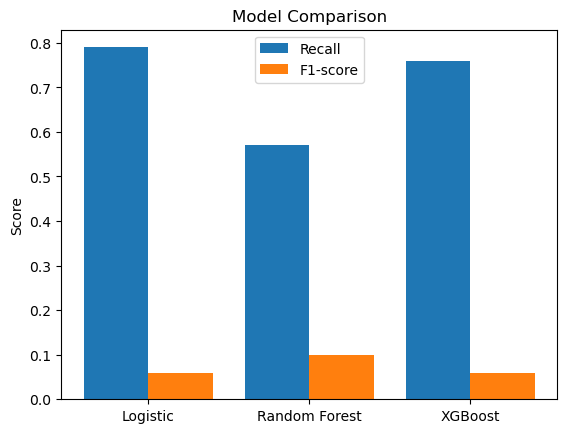

In [19]:
import matplotlib.pyplot as plt

models = ['Logistic', 'Random Forest', 'XGBoost']
recalls = [0.79, 0.57, 0.76]
f1_scores = [0.06, 0.10, 0.06]

x = range(len(models))
plt.bar(x, recalls, width=0.4, label='Recall', align='center')
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1-score', align='center')
plt.xticks([i + 0.2 for i in x], models)
plt.ylabel('Score')
plt.title('Model Comparison')
plt.legend()
plt.show()

#### Explanation
Based on evaluation metrics, I selected the Random Forest model for further interpretation.
The SHAP (SHapley Additive exPlanations) method is applied to this model to understand the contribution of each feature to return prediction.

#### Conclusion
- Lower review scores are moderately associated with higher return likelihood.
- Product category significantly impacts return rate, suggesting a potential for targeted quality control.
- Random Forest model performed best in balancing recall and precision for return prediction.
- SHAP analysis (see app.py) further explains feature contributions and supports interpretability.

#### - Save the Trained Model and Training Data

In [20]:
import joblib

joblib.dump(rf_model, "model.pkl")

['model.pkl']

In [21]:
# Make csv file for X_train data
X_train.to_csv("X_train.csv", index=False)

# Make csv file for y_train data
y_train.to_csv("y_train.csv", index=False)

# Make csv file for df
df.to_csv("olist_cleaned.csv", index=False)

In [22]:
# Check the return status count
y_train.value_counts(normalize=True)

return_status
0    0.995317
1    0.004683
Name: proportion, dtype: float64